# Dynamics 365 Business Central Troubleshooting Guide (TSG) - Extensions

This notebook contains Kusto queries that can help getting to the root cause of an issue with extensions for one or more environments. 

NB! Some of the signal used in this notebook is only available in newer versions of Business Central, so check the version of your environment if some sections do not return any data. The signal documentation states in which version a given signal was introduced.

## 1\. Get setup: Load up Python libraries and connect to Application Insights

First you need to set the notebook Kernel to Python3, 

load the KQLmagic module (did you install it? If not, go here to get install instructions <span style="color: rgb(33, 33, 33); font-family: Consolas, &quot;Courier New&quot;, monospace; font-size: 12px; white-space: pre;">&nbsp;<a href="https://github.com/microsoft/BCTech/tree/master/samples/AppInsights/TroubleShootingGuides" data-href="https://github.com/microsoft/BCTech/tree/master/samples/AppInsights/TroubleShootingGuides" title="https://github.com/microsoft/BCTech/tree/master/samples/AppInsights/TroubleShootingGuides" is-absolute="false">https://github.com/microsoft/BCTech/tree/master/samples/AppInsights/TroubleShootingGuides</a></span>) 

and connect to your Application Insights resource (get appid and appkey from the API access page in the Application Insights portal)


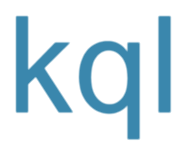

In [5]:
# load the KQLmagic module
%reload_ext Kqlmagic

In [2]:
# Connect to the Application Insights API
%kql appinsights://appid='<add app id from the Application Insights portal>';appkey='<add API key from the Application Insights portal>'

## 2\. Define filters

This workbook is designed for troubleshooting extensions. Please provide values for aadTenantId, environmentName, and extensionId (or use a config file).

You can also specify limits to the period of time that the analysis should include.

In [3]:
# Add values for AAD tenant id, environment name, and extension id.
# It is possible to leave one or more values blank (if you want to analyze across all values of the parameter)

# You can either use configuration file (INI file format) or set filters directly. 

# If you specify a config file, then variables set here takes precedence over manually set filter variables
# config file name and directory (full path)
configFile = "c:\\tmp\\notebook.ini"


# Add AAD tenant id and environment name here (or leave blank)
aadTenantId = ""
environmentName = ""
extensionId = ""

# date filters for the analysis
# use YYYY-MM-DD format for the dates (ISO 8601)
startDate = "2021-11-20"
endDate = "2022-01-01"



# Do not edit this code section
import configparser
config = configparser.ConfigParser()

config.read(configFile)

if bool(config.defaults()):
    if config.has_option('DEFAULT', 'aadTenantId'):
        aadTenantId = config['DEFAULT']['aadTenantId']
    if config.has_option('DEFAULT', 'environmentName'):
        environmentName = config['DEFAULT']['environmentName']
    if config.has_option('DEFAULT', 'extensionId'):
        extensionId = config['DEFAULT']['extensionId']
    if config.has_option('DEFAULT', 'startDate'):    
        startDate = config['DEFAULT']['startDate']
    if config.has_option('DEFAULT', 'endDate'):
        endDate = config['DEFAULT']['endDate']

print("Using these parameters for the analysis:")
print("----------------------------------------")
print("aadTenantId         " + aadTenantId)
print("environmentName     " + environmentName)
print("extensionId         " + extensionId)
print("startDate           " + startDate)
print("endDate             " + endDate)

Using these parameters for the analysis:
----------------------------------------
aadTenantId         
environmentName     
extensionId         
startDate           2021-11-20
endDate             2022-01-01


# Analyze extension events
Now you can run Kusto queries to look for possible root causes for issues about extensions.

Either click **Run All** above to run all sections, or scroll down to the type of analysis you want to do and manually run queries

## Extension event overview

Event telemetry docs: 
* https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-extension-lifecycle-trace
* https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-extension-update-trace

KQL samples: https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/ExtensionLifecycle.kql

In [4]:
%%kql
//
// extension event types stats 
// 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId in ('RT0010', 'LC0010', 'LC0011', 'LC0012', 'LC0013', 'LC0014', 'LC0015', 'LC0016', 'LC0017', 'LC0018', 'LC0019', 'LC0020', 'LC0021', 'LC0022', 'LC0023')    
| extend aadTenantId=tostring( customDimensions.aadTenantId)
       , environmentName=tostring( customDimensions.environmentName )
       , extensionId=tostring( customDimensions.extensionId )
       , eventId=tostring(customDimensions.eventId)
| extend eventMessageShort= strcat( case(
              eventId=='RT0010', 'Update failed (upgrade code)'
            , eventId=='LC0011', 'Install failed'
            , eventId=='LC0012', 'Synch succeeded'
            , eventId=='LC0013', 'Synch failed'           
            , eventId=='LC0014', 'Publish succeeded'
            , eventId=='LC0015', 'Publish failed'
            , eventId=='LC0016', 'Un-install succeeded'
            , eventId=='LC0017', 'Un-install failed'
            , eventId=='LC0018', 'Un-publish succeeded'
            , eventId=='LC0019', 'Un-publish failed'
            , eventId=='LC0020', 'Compilation succeeded'
            , eventId=='LC0021', 'Compilation failed'
            , eventId=='LC0022', 'Update succeeded'
            , eventId=='LC0023', 'Update failed (other)'
            ,                    'Unknown message'
         ), " (", eventId, ')'  )
| summarize count=count() by eventType=eventMessageShort
| order by eventType
| render barchart with (title='Extension lifecycle event overview', legend=hidden)

[]

In [ ]:
%%kql
//
// top 100 extension events
// 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId in ('RT0010', 'LC0010', 'LC0011', 'LC0012', 'LC0013', 'LC0014', 'LC0015', 'LC0016', 'LC0017', 'LC0018', 'LC0019', 'LC0020', 'LC0021', 'LC0022', 'LC0023')    
| extend aadTenantId=tostring( customDimensions.aadTenantId)
       , environmentName=tostring( customDimensions.environmentName )
       , extensionId=tostring( customDimensions.extensionId )
       , extensionName=tostring( customDimensions.extensionName )
       , eventId=tostring(customDimensions.eventId)       
| extend eventMessageShort= strcat( case(
              eventId=='RT0010', 'Update failed (upgrade code)'
            , eventId=='LC0011', 'Install failed'
            , eventId=='LC0012', 'Synch succeeded'
            , eventId=='LC0013', 'Synch failed'           
            , eventId=='LC0014', 'Publish succeeded'
            , eventId=='LC0015', 'Publish failed'
            , eventId=='LC0016', 'Un-install succeeded'
            , eventId=='LC0017', 'Un-install failed'
            , eventId=='LC0018', 'Un-publish succeeded'
            , eventId=='LC0019', 'Un-publish failed'
            , eventId=='LC0020', 'Compilation succeeded'
            , eventId=='LC0021', 'Compilation failed'
            , eventId=='LC0022', 'Update succeeded'
            , eventId=='LC0023', 'Update failed (other)'
            ,                    'Unknown message'
         ), " (", eventId, ')'  )
| project timestamp, eventMessageShort, extensionName, aadTenantId, environmentName, extensionId
| order by aadTenantId, environmentName, extensionId, timestamp asc
| limit 100

## Extension failures

Event telemetry docs: 
* https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-extension-lifecycle-trace
* https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-extension-update-trace

In [ ]:
%%kql
//
// extension event failure overview
// 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId in ('RT0010', 'LC0011', 'LC0013', 'LC0015', 'LC0017', 'LC0019', 'LC0021', 'LC0023')    
| extend aadTenantId=tostring( customDimensions.aadTenantId)
       , environmentName=tostring( customDimensions.environmentName )
       , extensionId=tostring( customDimensions.extensionId )
       , eventId=tostring(customDimensions.eventId)
| extend eventMessageShort= strcat( case(
              eventId=='RT0010', 'Update failed (upgrade code)'
            , eventId=='LC0011', 'Install failed'
            , eventId=='LC0013', 'Synch failed'           
            , eventId=='LC0015', 'Publish failed'
            , eventId=='LC0017', 'Un-install failed'
            , eventId=='LC0019', 'Un-publish failed'
            , eventId=='LC0021', 'Compilation failed'
            , eventId=='LC0023', 'Update failed (other)'
            ,                    'Unknown message'
         ), " (", eventId, ')'  )
| summarize count=count() by eventType=eventMessageShort
| order by eventType
| render barchart with (title='Failure type overview', xtitle="", legend=hidden)

In [ ]:
%%kql
//
// top 100 latest extension event failure details
// 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)
    and customDimensions.eventId in ('RT0010', 'LC0011', 'LC0013', 'LC0015', 'LC0017', 'LC0019', 'LC0021', 'LC0023')    
| extend aadTenantId=tostring( customDimensions.aadTenantId)
       , environmentName=tostring( customDimensions.environmentName )
       , extensionId=tostring( customDimensions.extensionId )
       , eventId=tostring(customDimensions.eventId)
       , extensionName=tostring(customDimensions.extensionName)
| extend eventMessageShort= strcat( case(
              eventId=='RT0010', 'Update failed (upgrade code)'
            , eventId=='LC0011', 'Install failed'
            , eventId=='LC0013', 'Synch failed'           
            , eventId=='LC0015', 'Publish failed'
            , eventId=='LC0017', 'Un-install failed'
            , eventId=='LC0019', 'Un-publish failed'
            , eventId=='LC0021', 'Compilation failed'
            , eventId=='LC0023', 'Update failed (other)'
            ,                    'Unknown message'
         ), " (", eventId, ')'  )
| project timestamp, extensionName, eventType=eventMessageShort
, version=customDimensions.extensionVersion
, failureReason=customDimensions.failureReason
, aadTenantId, environmentName, extensionId
| order by timestamp desc
| limit 100

In [ ]:
%%kql
//
// top 20 latest update failures (due to upgrade code)
// 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)
    and customDimensions.eventId == 'RT0010'
| extend aadTenantId=tostring( customDimensions.aadTenantId)
       , environmentName=tostring( customDimensions.environmentName )
       , extensionId=tostring( customDimensions.extensionId )
       , eventId=tostring(customDimensions.eventId)
       , extensionName=tostring(customDimensions.extensionName)
| project timestamp, extensionName
, version=customDimensions.extensionVersion
, targetedVersion =customDimensions.extensionTargetedVersion
, failureType =customDimensions.failureType
, alStackTrace =customDimensions.alStackTrace
, companyName = customDimensions.companyName
, extensionPublisher = customDimensions.extensionPublisher
, aadTenantId, environmentName, extensionId
| order by timestamp desc
| limit 20

In [ ]:
%%kql
//
// top 20 latest synch failures
// 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)
    and customDimensions.eventId == 'LC0013'
| extend aadTenantId=tostring( customDimensions.aadTenantId)
       , environmentName=tostring( customDimensions.environmentName )
       , extensionId=tostring( customDimensions.extensionId )
       , eventId=tostring(customDimensions.eventId)
       , extensionName=tostring(customDimensions.extensionName)
| project timestamp, extensionName
, version=customDimensions.extensionVersion
, failureReason=customDimensions.failureReason
, publishedAs = customDimensions.extensionPublishedAs
, extensionPublisher = customDimensions.extensionPublisher
, extensionScope = customDimensions.extensionScope
, extensionSynchronizationMode = customDimensions.extensionSynchronizationMode
, aadTenantId, environmentName, extensionId
| order by timestamp desc
| limit 20

In [ ]:
%%kql
//
// top 20 latest compilation failures
// 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)
    and customDimensions.eventId == 'LC0021'
| extend aadTenantId=tostring( customDimensions.aadTenantId)
       , environmentName=tostring( customDimensions.environmentName )
       , extensionId=tostring( customDimensions.extensionId )
       , eventId=tostring(customDimensions.eventId)
       , extensionName=tostring(customDimensions.extensionName)
| project timestamp, extensionName
, version=customDimensions.extensionVersion
, failureReason=customDimensions.failureReason
, compilationResult = customDimensions.extensionCompilationResult
, compilationDependencyList = customDimensions.extensionCompilationDependencyList
, publisher = customDimensions.extensionPublisher
, publishedAs = customDimensions.extensionPublishedAs
, extensionScope = customDimensions.extensionScope
, aadTenantId, environmentName, extensionId
| order by timestamp desc
| limit 20